In [23]:
import sys
import os
from PIL import Image

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid


In [24]:
DEVICE = torch.device('mps')
BATCH_SIZE = 32
NUM_EPOCHS = 150

In [25]:
linear = nn.Linear(in_features=4096, out_features=10)
conv = nn.Conv2d(in_channels=3, out_channels=9, kernel_size=3, stride=1, padding=1)
relu = nn.ReLU(False)

In [26]:
x = torch.randn(4096)
y = linear(x)
y.size()

torch.Size([10])

In [27]:
x = torch.randn((1, 3, 7, 7))
y = conv(x)
z = relu(x)

In [28]:
y.size()

torch.Size([1, 9, 7, 7])

In [29]:
z

tensor([[[[4.4687e-01, 1.3604e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           8.7490e-01, 1.8166e+00],
          [5.6093e-01, 1.3124e+00, 9.3466e-01, 9.9655e-01, 1.5220e-01,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 1.4487e+00, 1.9942e-01, 7.7622e-04,
           1.5016e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 2.2766e-01, 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.3096e+00, 0.0000e+00, 4.5284e-01, 0.0000e+00, 1.6721e+00,
           7.8344e-01, 5.1989e-01],
          [0.0000e+00, 9.0072e-01, 9.3491e-01, 0.0000e+00, 5.2193e-01,
           0.0000e+00, 9.7999e-01],
          [0.0000e+00, 9.5929e-01, 6.2406e-02, 2.4267e-01, 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[1.5731e+00, 0.0000e+00, 0.0000e+00, 3.4814e-01, 1.0081e+00,
           0.0000e+00, 8.3323e-02],
          [0.0000e+00, 5.4192e-01, 0.0000e+00, 1.0204e+00, 4.7467e-01,
           5.7837e-02, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 

In [30]:
for name, value in linear.named_parameters():
    print(name)
    print(value.size())
    print()

weight
torch.Size([10, 4096])

bias
torch.Size([10])



## Implement a Neural Network

In [31]:
class Net(nn.Module):
    def __init__(self, num_channels):
        super(Net, self).__init__()
        self.num_channels = num_channels
        self.conv1 = nn.Conv2d(3, self.num_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(
            self.num_channels, self.num_channels * 2, kernel_size=3, stride=1, padding=1
        )
        self.conv3 = nn.Conv2d(
            self.num_channels * 2,
            self.num_channels * 4,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.fc1 = nn.Linear(self.num_channels * 256, self.num_channels * 4)
        self.fc2 = nn.Linear(self.num_channels * 4, 6)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(nn.functional.max_pool2d(x, 2))
        x = self.conv2(x)
        x = nn.functional.relu(nn.functional.max_pool2d(x, 2))
        x = self.conv3(x)
        x = nn.functional.relu(nn.functional.max_pool2d(x, 2))

        # Flatten
        x = x.view(-1, self.num_channels * 256)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.softmax(x)

        return x


## Load Data in PyTorch

In [32]:
!ls ../Datasets/64x64_SIGNS

test_signs  train_signs val_signs


In [33]:
sys.path.append('../functions')

In [34]:
from plot_helpers import imshow

In [35]:
class SignsDatasets(Dataset):
    def __init__(self, base_dir, split="train", transform=None):
        path = os.path.join(base_dir, f"{split}_signs")
        files = os.listdir(path)

        self.filenames = [os.path.join(path, f) for f in files if f.endswith(".jpg")]
        self.targets = [int(f[0]) for f in files]
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        image = Image.open(self.filenames[index])
        if self.transform:
            image = self.transform(image)

        return image, self.targets[index]


In [36]:
signs = SignsDatasets('../Datasets/64x64_SIGNS/', split='train')

In [37]:
len(signs)

864

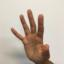

In [38]:
signs[56][0]

### Preprocess the images

In [39]:
train_set = SignsDatasets('../Datasets/64x64_SIGNS/', split='train', transform=transforms.ToTensor())

In [40]:
dataloader = DataLoader(train_set, batch_size=BATCH_SIZE)

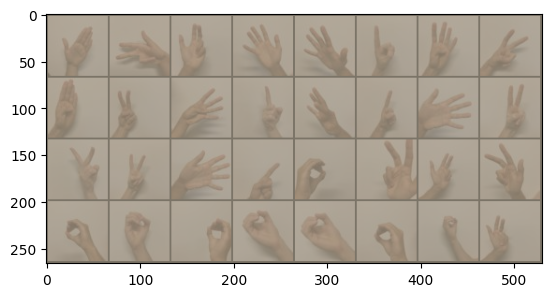

tensor([5, 3, 3, 5, 5, 1, 4, 2, 4, 2, 4, 1, 4, 1, 5, 2, 2, 2, 5, 1, 0, 3, 3, 3,
        0, 0, 0, 0, 0, 0, 0, 3])


In [41]:
for inputs, targets in dataloader:
    out = make_grid(inputs)
    imshow(out)
    print(targets)
    break

In [42]:
net = Net(32).to(DEVICE)
loss_fn = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

In [43]:
class RunningMetric():
    def __init__(self):
        self.S = 0
        self.N = 0
    
    def update(self, value, size):
        self.S += value
        self.N += size
        
    def __call__(self):
        return self.S/float(self.N)

In [44]:
for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}')
    print('-' * 10)

    running_loss = RunningMetric()
    running_acc = RunningMetric()

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        
        batch_size = inputs.size()[0]
        running_loss.update(loss.item() * batch_size, batch_size)
        running_acc.update(torch.sum(preds == targets).float(), batch_size)
        
    print(f'Loss: {running_loss():.4f} Acc: {running_acc():.4f}')

Epoch 1/150
----------


/var/folders/bs/jxzw14n53ksgt9_q98rq0_0m0000gn/T/ipykernel_2834/1565532523.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.softmax(x)


Loss: -0.1667 Acc: 0.1644
Epoch 2/150
----------
Loss: -0.1667 Acc: 0.1644
Epoch 3/150
----------
Loss: -0.1668 Acc: 0.1644
Epoch 4/150
----------
Loss: -0.1668 Acc: 0.1644
Epoch 5/150
----------
Loss: -0.1668 Acc: 0.1644
Epoch 6/150
----------
Loss: -0.1668 Acc: 0.1644
Epoch 7/150
----------
Loss: -0.1668 Acc: 0.1644
Epoch 8/150
----------
Loss: -0.1668 Acc: 0.1644
Epoch 9/150
----------
Loss: -0.1668 Acc: 0.1644
Epoch 10/150
----------
Loss: -0.1669 Acc: 0.1644
Epoch 11/150
----------
Loss: -0.1669 Acc: 0.1644
Epoch 12/150
----------
Loss: -0.1669 Acc: 0.1644
Epoch 13/150
----------
Loss: -0.1669 Acc: 0.1644
Epoch 14/150
----------
Loss: -0.1669 Acc: 0.1644
Epoch 15/150
----------
Loss: -0.1669 Acc: 0.1644
Epoch 16/150
----------
Loss: -0.1669 Acc: 0.1644
Epoch 17/150
----------
Loss: -0.1669 Acc: 0.1644
Epoch 18/150
----------
Loss: -0.1669 Acc: 0.1644
Epoch 19/150
----------
Loss: -0.1670 Acc: 0.1644
Epoch 20/150
----------
Loss: -0.1670 Acc: 0.1644
Epoch 21/150
----------
Loss: -0